In [87]:
import requests
import json

API_TOKEN = '6879-vSO0LbBYyj9Oi1ami5cqD9pa3N6Q8SN4bdXR_Sv3xO0'
GROUP_ID = 'dKymJJpZ'
BASE_URL = 'https://api.hypothes.is/api/search'

# Headers for the request
headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Content-Type': 'application/json'
}

# Define parameters for pagination and fetching data
params = {
    'group': GROUP_ID,  # The group ID
    'limit': 200,       # Number of annotations per page (maximum is 200)
    'sort': 'created',  # Sort by creation date
    'order': 'asc'      # Ascending order (oldest first)
}

def fetch_annotations(params):
    """Fetch all annotations from the specified group using pagination."""
    all_annotations = []
    search_after = None
    
    while True:
        # If there is a search_after parameter, append it to the request
        if search_after:
            params['search_after'] = search_after
        
        # Make the request to the Hypothes.is API
        response = requests.get(BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            data = response.json()
            annotations = data.get('rows', [])
            
            # Add the fetched annotations to the list
            all_annotations.extend(annotations)
            
            # Check if we have more annotations to fetch (pagination check)
            if len(annotations) < params['limit']:
                break  # No more annotations to fetch
            # Set the search_after for the next request (to paginate)
            search_after = annotations[-1]['created']
        else:
            print(f"Error fetching annotations: {response.status_code}, {response.text}")
            break

    return all_annotations

def save_annotations_to_json(annotations, filename="vhl_pull.json"):
    """Save the list of annotations to a JSON file."""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(annotations, f, indent=4)
    print(f"Annotations saved to {filename}")

def main():
    # Fetch annotations from the group
    print("Fetching annotations...")
    annotations = fetch_annotations(params)
    
    if annotations:
        # Save annotations to a JSON file
        save_annotations_to_json(annotations)
    else:
        print("No annotations found.")

if __name__ == "__main__":
    main()

Fetching annotations...
Annotations saved to vhl_pull.json


In [88]:
import json

def analyze_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    def get_type(value):
        if isinstance(value, dict):
            return "object"
        elif isinstance(value, list):
            return "array"
        elif isinstance(value, str):
            return "string"
        elif isinstance(value, int):
            return "integer"
        elif isinstance(value, float):
            return "float"
        elif isinstance(value, bool):
            return "boolean"
        elif value is None:
            return "null"
        else:
            return str(type(value))

    def analyze_structure(obj, prefix=''):
        if isinstance(obj, dict):
            for key, value in obj.items():
                print(f"{prefix}{key}: {get_type(value)}")
                if isinstance(value, (dict, list)):
                    analyze_structure(value, prefix + '  ')
        elif isinstance(obj, list) and len(obj) > 0:
            print(f"{prefix}(array items): {get_type(obj[0])}")
            if isinstance(obj[0], (dict, list)):
                analyze_structure(obj[0], prefix + '  ')

    analyze_structure(data)

analyze_json('vhl_pull.json')

(array items): object
  id: string
  created: string
  updated: string
  user: string
  uri: string
  text: string
  tags: array
  group: string
  permissions: object
    read: array
      (array items): string
    admin: array
      (array items): string
    update: array
      (array items): string
    delete: array
      (array items): string
  target: array
    (array items): object
      source: string
      selector: array
        (array items): object
          type: string
          endOffset: integer
          startOffset: integer
          endContainer: string
          startContainer: string
  document: object
    title: array
      (array items): string
  links: object
    html: string
    incontext: string
    json: string
  user_info: object
    display_name: null
  flagged: integer
  hidden: integer


C:\Users\mjmcc\AppData\Local\Temp\ipykernel_33468\1173540279.py:35: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



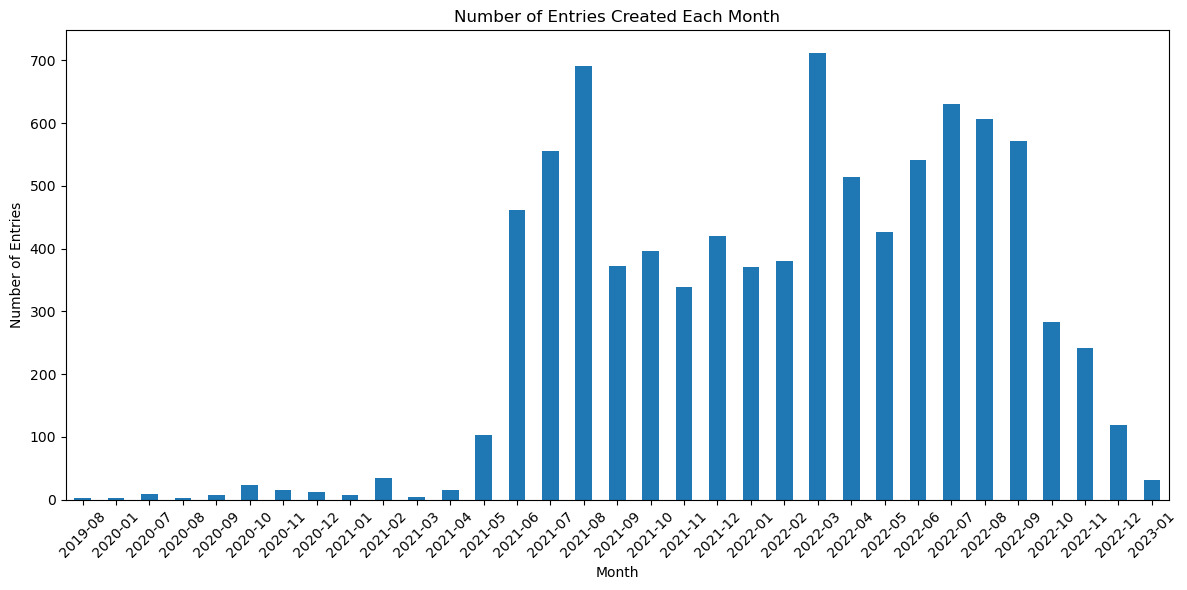

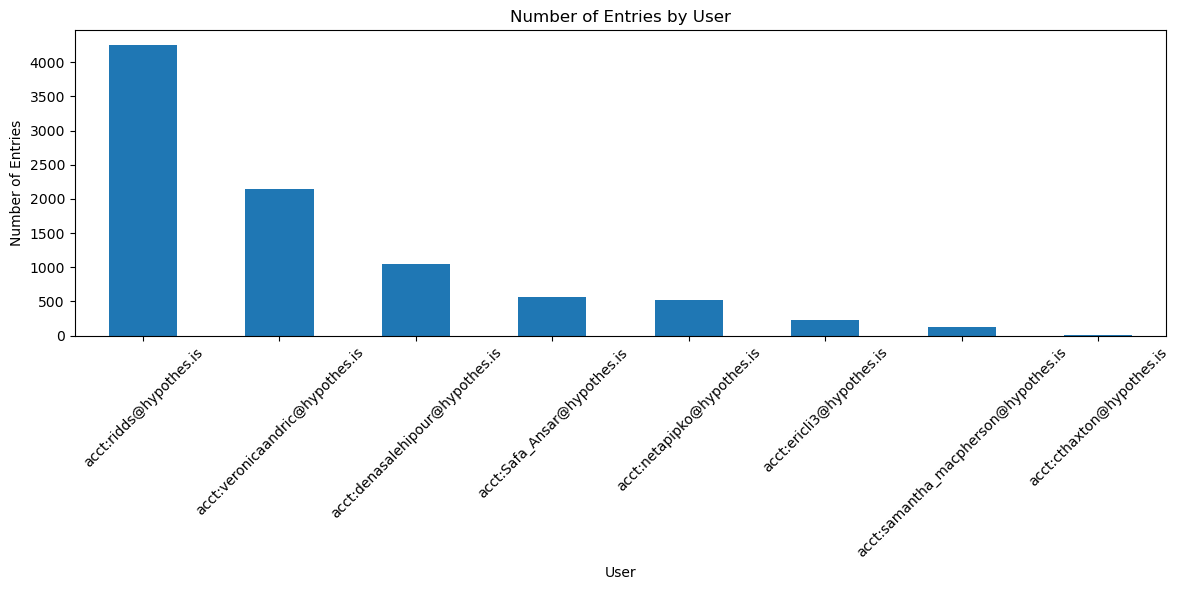

First entry was made on: 2019-08-29T15:28:13.482676+00:00
Last entry was made on: 2023-10-03T16:13:03.949589+00:00


In [89]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def extract_dates_and_users(data):
    created_dates = []
    updated_dates = []
    users = []

    for item in data:
        created_dates.append(item.get('created'))
        updated_dates.append(item.get('updated'))
        users.append(item.get('user'))

    return created_dates, updated_dates, users

def plot_histograms(created_dates, updated_dates, users):
    # Convert string dates to datetime objects
    created_dates = pd.to_datetime(created_dates)
    updated_dates = pd.to_datetime(updated_dates)

    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'created': created_dates,
        'updated': updated_dates,
        'user': users
    })

    # Plot histogram of entries by month
    df['created_month'] = df['created'].dt.to_period('M')
    created_counts = df['created_month'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    created_counts.plot(kind='bar')
    plt.title('Number of Entries Created Each Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Entries')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot histogram of entries by user
    user_counts = df['user'].value_counts()

    plt.figure(figsize=(12, 6))
    user_counts.plot(kind='bar')
    plt.title('Number of Entries by User')
    plt.xlabel('User')
    plt.ylabel('Number of Entries')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Load JSON data
data = load_json('vhl_pull.json')

# Extract relevant data
created_dates, updated_dates, users = extract_dates_and_users(data)

# Plot histograms
plot_histograms(created_dates, updated_dates, users)

# Find the first and last entry dates
first_entry_date = min(created_dates)
last_entry_date = max(updated_dates)

print(f"First entry was made on: {first_entry_date}")
print(f"Last entry was made on: {last_entry_date}")

In [92]:
import json
import pandas as pd

def normalize_tag_name(tag):
    tag_lower = tag.lower()
    if tag_lower in ['cllinvarid', 'clinvar']:
        return 'clinvarid'
    elif tag_lower in ['cdna', 'cdnaposition']:
        return 'cdnaposition'
    elif tag_lower == 'ageofpresentatoin':
        return 'ageofpresentation'
    return tag_lower

def clean_clinvarid(value):
    # Extract only numeric values from the clinvarid
    return ''.join(filter(str.isdigit, value))

def extract_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    extracted_data = []
    all_tag_types = set()
    
    for item in data:
        if item.get('tags'):  # Only process items that have tags
            extracted_item = {
                'id': item.get('id'),
                'uri': item.get('uri'),
                'text': item.get('text'),
                'document_title': ', '.join(item.get('document', {}).get('title', []))
            }
            
            # Process tags
            tags = item.get('tags', [])
            tag_dict = {}
            has_disease_entity = False
            for tag in tags:
                if ':' in tag:
                    key, value = tag.split(':', 1)
                    key = normalize_tag_name(key)
                    all_tag_types.add(key)
                    if key in tag_dict:
                        tag_dict[key] += f';{value}'
                    else:
                        tag_dict[key] = value
                    if key == 'diseaseentity':
                        has_disease_entity = True
                else:
                    key = normalize_tag_name(tag)
                    all_tag_types.add(key)
                    tag_dict[key] = 'True'

            if has_disease_entity:
                # Clean clinvarid values
                if 'clinvarid' in tag_dict:
                    tag_dict['clinvarid'] = clean_clinvarid(tag_dict['clinvarid'])
                
                extracted_item.update(tag_dict)
                extracted_data.append(extracted_item)
    
    # Create DataFrame
    df = pd.DataFrame(extracted_data)
    
    # Ensure all tag columns exist, fill with empty string if missing
    for tag_type in all_tag_types:
        if tag_type not in df.columns:
            df[tag_type] = ''
    
    # Keep only specified columns
    columns_to_keep = [
        'id', 'uri', 'text', 'document_title', 'diseaseentity', 'mutation',
        'clinvarid', 'assumedrefseq', 'cdnaposition', 'civicname','aminoacidchange',
        'proteinposition', 'inheritancepattern', 'ethnicity',
        'ageofpresentation', 'familypedigree', 'mutationtype', 
        'familial', 'caid'
    ]
    
    # Filter DataFrame to keep only specified columns
    df = df[columns_to_keep]
    
    # Keep only rows with a non-empty clinvarid
    df = df[df['clinvarid'].str.strip() != '']
    
    return df

# Extract data and create DataFrame
df = extract_data('vhl_pull.json')

# Display the first few rows of the DataFrame
print(df.head())

# Print the total number of entries with a non-empty clinvarid
print(f"\nTotal number of entries with a non-empty clinvarid: {len(df)}")

# Print all column names
print("\nColumns in the DataFrame:")
print(df.columns.tolist())

# Save to CSV (optional)
# df.to_csv('extracted_data_with_clinvarid.csv', index=False)

                       id                                                uri  \
0  m1m6XDh1EeqI35sScGxC9g  http://www.cancerjournal.net/article.asp?issn=...   
1  X2gLpsFlEeqvLRuR7ER4lA  https://www.spandidos-publications.com/10.3892...   
2  VZvVJsFvEeq8rJ_nNc1xzw  https://www.spandidos-publications.com/10.3892...   
3  FHaTeMGxEeqDfSvtG5v_5A  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...   
4  xoOBTv6MEeq1tJsnfTgAYw  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...   

                                                text  \
0  **Case:** 1; 29Y; M \n**DiseaseAssertion:** VH...   
1  PatientID: proband (III:2)\n\nKindredID: 1\n\n...   
2  PatientID: III:4\n\nKindredID: 1\n\nCase: M, A...   
3  PatientID: None \n\nKindredID: 1\n\nCase: F, 4...   
4  PatientID: N/A\n\nKindredID: 1\n\nCase: Sex Un...   

                                      document_title  \
0  Adrenal adenoma in von Hippel–Lindau syndrome:...   
1  Identification of a VHL Gene Mutation in a Chi...   
2  Identificat

In [85]:
import json
import pandas as pd

def normalize_tag_name(tag):
    tag_lower = tag.lower()
    if tag_lower in ['cllinvarid', 'clinvar']:
        return 'clinvarid'
    elif tag_lower in ['cdna', 'cdnaposition']:
        return 'cdnaposition'
    elif tag_lower == 'ageofpresentatoin':
        return 'ageofpresentation'
    return tag_lower

def clean_clinvarid(value):
    # Extract only numeric values from the clinvarid
    return ''.join(filter(str.isdigit, value))

def extract_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    extracted_data = []
    all_tag_types = set()
    
    for item in data:
        if item.get('tags'):  # Only process items that have tags
            extracted_item = {
                'id': item.get('id'),
                'uri': item.get('uri'),
                'text': item.get('text'),
                'document_title': ', '.join(item.get('document', {}).get('title', []))
            }
            
            # Process tags
            tags = item.get('tags', [])
            tag_dict = {}
            has_disease_entity = False
            for tag in tags:
                if ':' in tag:
                    key, value = tag.split(':', 1)
                    key = normalize_tag_name(key)
                    all_tag_types.add(key)
                    if key in tag_dict:
                        tag_dict[key] += f';{value}'
                    else:
                        tag_dict[key] = value
                    if key == 'diseaseentity':
                        has_disease_entity = True
                else:
                    key = normalize_tag_name(tag)
                    all_tag_types.add(key)
                    tag_dict[key] = 'True'

            if has_disease_entity:
                # Clean clinvarid values
                if 'clinvarid' in tag_dict:
                    tag_dict['clinvarid'] = clean_clinvarid(tag_dict['clinvarid'])
                
                extracted_item.update(tag_dict)
                extracted_data.append(extracted_item)
    
    # Create DataFrame
    df = pd.DataFrame(extracted_data)
    
    # Ensure all tag columns exist, fill with empty string if missing
    for tag_type in all_tag_types:
        if tag_type not in df.columns:
            df[tag_type] = ''
    
    # Keep only specified columns
    columns_to_keep = [
        'id', 'uri', 'text', 'document_title', 'diseaseentity', 'mutation',
        'clinvarid', 'assumedrefseq', 'cdnaposition', 'civicname','aminoacidchange',
        'proteinposition', 'inheritancepattern', 'ethnicity',
        'ageofpresentation', 'familypedigree', 'mutationtype', 
        'familial', 'caid'
    ]
    
    # Filter DataFrame to keep only specified columns
    df = df[columns_to_keep]
    
    return df

# Extract data and create DataFrame
df = extract_data('vhl_pull.json')

# Display the first few rows of the DataFrame
print(df.head())

# Print the total number of entries with diseaseentity
print(f"\nTotal number of entries with diseaseentity: {len(df)}")

# Print all column names
print("\nColumns in the DataFrame:")
print(df.columns.tolist())

# Save to CSV (optional)
# df.to_csv('extracted_data_with_diseaseentity.csv', index=False)

                       id                                                uri  \
0  m1m6XDh1EeqI35sScGxC9g  http://www.cancerjournal.net/article.asp?issn=...   
1  X2gLpsFlEeqvLRuR7ER4lA  https://www.spandidos-publications.com/10.3892...   
2  VZvVJsFvEeq8rJ_nNc1xzw  https://www.spandidos-publications.com/10.3892...   
3  FHaTeMGxEeqDfSvtG5v_5A  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...   
4  xoOBTv6MEeq1tJsnfTgAYw  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...   

                                                text  \
0  **Case:** 1; 29Y; M \n**DiseaseAssertion:** VH...   
1  PatientID: proband (III:2)\n\nKindredID: 1\n\n...   
2  PatientID: III:4\n\nKindredID: 1\n\nCase: M, A...   
3  PatientID: None \n\nKindredID: 1\n\nCase: F, 4...   
4  PatientID: N/A\n\nKindredID: 1\n\nCase: Sex Un...   

                                      document_title  \
0  Adrenal adenoma in von Hippel–Lindau syndrome:...   
1  Identification of a VHL Gene Mutation in a Chi...   
2  Identificat

In [101]:
df

,id,uri,text,document_title,diseaseentity,mutation,clinvarid,assumedrefseq,cdnaposition,civicname,...,familypedigree,mutationtype,familial,caid,accession_version,title,description,last_evaluated,review_status,fda_recognized_database
0,m1m6XDh1EeqI35sScGxC9g,http://www.cancerjournal.net/article.asp?issn=...,**Case:** 1; 29Y; M \n**DiseaseAssertion:** VH...,Adrenal adenoma in von Hippel–Lindau syndrome:...,VHL;spinal hemangioblastoma;multiple renal cys...,Germline,223190,NM_000551.3,c.340+1G>A,c.340+1G>A,...,NaN,NaN,NaN,NaN,VCV000223190,NM_000551.4(VHL):c.340+1G>A,Pathogenic,2023/07/25 00:00,"criteria provided, multiple submitters, no con...",
1,X2gLpsFlEeqvLRuR7ER4lA,https://www.spandidos-publications.com/10.3892...,PatientID: proband (III:2)\n\nKindredID: 1\n\n...,Identification of a VHL Gene Mutation in a Chi...,VHL;hemangioblastoma,Germline,496057,NM_000551.3,NaN,H115Q(c.345C>A),...,True,missense_variant;transversion,True,NaN,VCV000496057,NM_000551.4(VHL):c.345C>A (p.His115Gln),Pathogenic/Likely pathogenic,2019/03/19 00:00,"criteria provided, multiple submitters, no con...",
2,VZvVJsFvEeq8rJ_nNc1xzw,https://www.spandidos-publications.com/10.3892...,"PatientID: III:4\n\nKindredID: 1\n\nCase: M, A...",Identification of a VHL Gene Mutation in a Chi...,asymptomatic,Germline,496057,NM_000551.3,345,H115Q(c.345C>A),...,True,missense_variant;transversion,True,NaN,VCV000496057,NM_000551.4(VHL):c.345C>A (p.His115Gln),Pathogenic/Likely pathogenic,2019/03/19 00:00,"criteria provided, multiple submitters, no con...",
3,FHaTeMGxEeqDfSvtG5v_5A,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,"PatientID: None \n\nKindredID: 1\n\nCase: F, 4...",An Advanced Well-differentiated Pancreatic Neu...,VHL;pancreaticcysts;pancreaticendocrinetumor;h...,Germline,288749,NM_000551.3,394,Q132*(c.394C>T),...,NaN,missense_variant;transition,NaN,CA10606205,VCV000288749,NM_000551.4(VHL):c.394C>T (p.Gln132Ter),Pathogenic,2024/01/13 00:00,"criteria provided, multiple submitters, no con...",
4,xoOBTv6MEeq1tJsnfTgAYw,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,PatientID: N/A\n\nKindredID: 1\n\nCase: Sex Un...,Spinal Cord Hemangioblastoma : Diagnosis and C...,VHL;spinalhemangioblastoma,Germline,196284,NM_000551.3,586,K196*(c.586A＞T),...,NaN,stop_gained,NaN,CA020507,VCV000196284,NM_000551.4(VHL):c.586A>T (p.Lys196Ter),Pathogenic,2024/06/25 00:00,reviewed by expert panel,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,Avn_rn1hEe2Hd0updXAbMg,https://www.sciencedirect.com/science/article/...,"\nPatientID: N/A\n\nKindredID: 3\n\nCase: F, 5...",Extraneuraxial hemangioblastoma: A clinicopath...,VHL;cerebellarhemangioblastoma,Somatic,428800,NM_000551.3,163,P25L(c.74C>T)andD126Rfs*6(c.375_376insA)andE55...,...,NaN,minus_1_frameshift_variant,True,NaN,VCV000428800,NM_000551.4(VHL):c.163del (p.Glu55fs),Pathogenic,2016/11/23 00:00,"criteria provided, single submitter",
4821,y2DZCIJ2Ee2ntMNTAA4WyA,https://www.nature.com/articles/s41525-022-002...,"PatientID: N/A\n\nKindredID: 1\n\nCase: M, 55Y...",VHL mosaicism: the added value of multi-tissue...,VHL;clearcellrenalcellcarcinoma;adrenalpheochr...,Germline;Somatic,223235,NaN,593,L198P(c.593T>C),...,NaN,missense_variant;transition,NaN,NaN,VCV000223235,NM_000551.4(VHL):c.593T>C (p.Leu198Pro),Likely pathogenic,2018/10/04 00:00,"criteria provided, multiple submitters, no con...",
4822,-pZZLpAwEe2XUwc_k61GKg,https://erc.bioscientifica.com/view/journals/e...,"\nGroupID: None\n\nCase: Sex Unknown, 63Y0M, D...",Calculating optimal surveillance for detection...,VHL;retinalcapillaryhemangioma;cerebellarheman...,Germline,161400,NaN,235,R79C(c.235C>T),...,NaN,missense_variant;transition,NaN,NaN,VCV000161400,NM_000551.4(VHL):c.235C>T (p.Arg79Cys),Uncertain significance,2024/04/22 00:00,"criteria provided, multiple submitters, no con...",
4824,pVfV2JBXEe2vRAOWmHp7ZA,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,"PatientID: 172\n\nKindredID: 68\n\nCase: F, 43...",Genotype-phenotype co

In [102]:
df.columns

Index(['id', 'uri', 'text', 'document_title', 'diseaseentity', 'mutation',
       'clinvarid', 'assumedrefseq', 'cdnaposition', 'civicname',
       'aminoacidchange', 'proteinposition', 'inheritancepattern', 'ethnicity',
       'ageofpresentation', 'familypedigree', 'mutationtype', 'familial',
       'caid', 'accession_version', 'title', 'description', 'last_evaluated',
       'review_status', 'fda_recognized_database'],
      dtype='object')

In [103]:
df.to_json('output.json', orient='records', indent=4)

In [96]:
df.columns

Index(['id', 'uri', 'text', 'document_title', 'diseaseentity', 'mutation',
       'clinvarid', 'assumedrefseq', 'cdnaposition', 'civicname',
       'aminoacidchange', 'proteinposition', 'inheritancepattern', 'ethnicity',
       'ageofpresentation', 'familypedigree', 'mutationtype', 'familial',
       'caid'],
      dtype='object')

In [78]:
import requests
import json

def query_clinvar(clinvar_id):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    esearch_url = f"{base_url}esearch.fcgi"
    esummary_url = f"{base_url}esummary.fcgi"
    
    # Search for the ClinVar ID
    search_params = {
        "db": "clinvar",
        "term": f"{clinvar_id}[VariationID]",
        "retmode": "json"
    }
    search_response = requests.get(esearch_url, params=search_params)
    search_data = search_response.json()
    
    if search_data["esearchresult"]["count"] == "0":
        return "No results found for this ClinVar ID"
    
    # Get the details for the found ID
    id_list = search_data["esearchresult"]["idlist"]
    if not id_list:
        return "No valid ID found for this ClinVar ID"
    
    summary_params = {
        "db": "clinvar",
        "id": ",".join(id_list),
        "retmode": "json"
    }
    summary_response = requests.get(esummary_url, params=summary_params)
    summary_data = summary_response.json()
    
    return analyze_pathogenicity(summary_data)

def analyze_pathogenicity(data):
    pathogenicity_info = []
    
    print("Raw API Response:")
    print(json.dumps(data, indent=2))
    
    for uid in data["result"]["uids"]:
        variant_data = data["result"][uid]
        print(f"\nVariant Data for UID {uid}:")
        print(json.dumps(variant_data, indent=2))
        
        clinical_significance = variant_data.get("clinical_significance", {})
        if isinstance(clinical_significance, dict):
            clinical_significance = clinical_significance.get("description", "N/A")
        variation_id = variant_data.get("variation_id", "N/A")
        variation_type = variant_data.get("variation_type", "N/A")
        
        pathogenicity_info.append({
            "clinical_significance": clinical_significance,
            "variation_id": variation_id,
            "variation_type": variation_type
        })
    
    return pathogenicity_info

# Example usage
clinvar_id = "2232"  # Replace with the actual ClinVar ID you want to look up
result = query_clinvar(clinvar_id)
print("\nFinal Result:")
print(json.dumps(result, indent=2))

Raw API Response:
{
  "header": {
    "type": "esummary",
    "version": "0.3"
  },
  "result": {
    "uids": [
      "2232"
    ],
    "2232": {
      "uid": "2232",
      "obj_type": "single nucleotide variant",
      "accession": "VCV000002232",
      "accession_version": "VCV000002232.57",
      "title": "NM_000551.4(VHL):c.598C>T (p.Arg200Trp)",
      "variation_set": [
        {
          "measure_id": "17271",
          "variation_xrefs": [
            {
              "db_source": "ClinGen",
              "db_id": "CA020510"
            },
            {
              "db_source": "UniProtKB",
              "db_id": "P40337#VAR_005779"
            },
            {
              "db_source": "OMIM",
              "db_id": "608537.0019"
            },
            {
              "db_source": "dbSNP",
              "db_id": "28940298"
            }
          ],
          "variation_name": "NM_000551.4(VHL):c.598C>T (p.Arg200Trp)",
          "cdna_change": "c.598C>T",
          "alia

In [84]:
import requests
import json

def query_clinvar(clinvar_id):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    esearch_url = f"{base_url}esearch.fcgi"
    esummary_url = f"{base_url}esummary.fcgi"
    
    search_params = {
        "db": "clinvar",
        "term": f"{clinvar_id}[VariationID]",
        "retmode": "json"
    }
    search_response = requests.get(esearch_url, params=search_params)
    search_data = search_response.json()
    
    if search_data["esearchresult"]["count"] == "0":
        return "No results found for this ClinVar ID"
    
    id_list = search_data["esearchresult"]["idlist"]
    if not id_list:
        return "No valid ID found for this ClinVar ID"
    
    summary_params = {
        "db": "clinvar",
        "id": ",".join(id_list),
        "retmode": "json"
    }
    summary_response = requests.get(esummary_url, params=summary_params)
    summary_data = summary_response.json()
    
    return analyze_variant_data(summary_data)

def analyze_variant_data(data):
    variant_info = []
    
    for uid in data["result"]["uids"]:
        variant_data = data["result"][uid]
        
        accession_version = variant_data.get("accession_version", "N/A")
        title = variant_data.get("title", "N/A")
        
        germline_classification = variant_data.get("germline_classification", {})
        description = germline_classification.get("description", "N/A")
        last_evaluated = germline_classification.get("last_evaluated", "N/A")
        review_status = germline_classification.get("review_status", "N/A")
        fda_recognized_database = germline_classification.get("fda_recognized_database", "N/A")
        
        variant_info.append({
            "accession_version": accession_version,
            "title": title,
            "germline_classification": {
                "description": description,
                "last_evaluated": last_evaluated,
                "review_status": review_status,
                "fda_recognized_database": fda_recognized_database
            }
        })
    
    return variant_info

# Example usage
clinvar_id = "2232"  # Replace with the actual ClinVar ID you want to look up
result = query_clinvar(clinvar_id)
print(json.dumps(result, indent=2))

[
  {
    "accession_version": "VCV000002232.57",
    "title": "NM_000551.4(VHL):c.598C>T (p.Arg200Trp)",
    "germline_classification": {
      "description": "Conflicting classifications of pathogenicity",
      "last_evaluated": "2024/09/22 00:00",
      "review_status": "criteria provided, conflicting classifications",
      "fda_recognized_database": ""
    }
  }
]


In [100]:
import requests
import json
import pandas as pd
import time

def query_clinvar(clinvar_id):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    esearch_url = f"{base_url}esearch.fcgi"
    esummary_url = f"{base_url}esummary.fcgi"
    
    search_params = {
        "db": "clinvar",
        "term": f"{clinvar_id}[VariationID]",
        "retmode": "json"
    }
    
    try:
        search_response = requests.get(esearch_url, params=search_params)
        search_response.raise_for_status()  # Raise an error for bad responses
        search_data = search_response.json()
        
        if not search_data.get("esearchresult") or search_data["esearchresult"].get("count") == "0":
            return None
        
        id_list = search_data["esearchresult"].get("idlist", [])
        if not id_list:
            return None
        
        summary_params = {
            "db": "clinvar",
            "id": ",".join(id_list),
            "retmode": "json"
        }
        
        summary_response = requests.get(esummary_url, params=summary_params)
        summary_response.raise_for_status()
        summary_data = summary_response.json()
        
        return analyze_variant_data(summary_data)
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except json.JSONDecodeError:
        print("Failed to decode JSON response")
    
    return None

def analyze_variant_data(data):
    variant_info = {
        "accession_version": "N/A",
        "title": "N/A",
        "description": "N/A",
        "last_evaluated": "N/A",
        "review_status": "N/A",
        "fda_recognized_database": "N/A"
    }
    
    for uid in data.get("result", {}).get("uids", []):
        variant_data = data["result"].get(uid, {})
        
        variant_info["accession_version"] = variant_data.get("accession", "N/A")
        variant_info["title"] = variant_data.get("title", "N/A")
        
        germline_classification = variant_data.get("germline_classification", {})
        variant_info["description"] = germline_classification.get("description", "N/A")
        variant_info["last_evaluated"] = germline_classification.get("last_evaluated", "N/A")
        variant_info["review_status"] = germline_classification.get("review_status", "N/A")
        variant_info["fda_recognized_database"] = germline_classification.get("fda_recognized_database", "N/A")
        
    return variant_info

# Assuming df is your existing DataFrame with a 'clinvarid' column
df['accession_version'] = ''
df['title'] = ''
df['description'] = ''
df['last_evaluated'] = ''
df['review_status'] = ''
df['fda_recognized_database'] = ''

for index, row in df.iterrows():
    clinvar_id = row['clinvarid']
    result = query_clinvar(clinvar_id)
    
    if result:
        df.at[index, 'accession_version'] = result['accession_version']
        df.at[index, 'title'] = result['title']
        df.at[index, 'description'] = result['description']
        df.at[index, 'last_evaluated'] = result['last_evaluated']
        df.at[index, 'review_status'] = result['review_status']
        df.at[index, 'fda_recognized_database'] = result['fda_recognized_database']
    
    # Introduce a delay between requests
    time.sleep(0.5)  # Adjust the sleep time as needed

# Display the updated DataFrame
print(df.head())

# Save to CSV (optional)
# df.to_csv('updated_extracted_data.csv', index=False)

Request failed: 500 Server Error: Internal Server Error for url: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=clinvar&term=93326%5BVariationID%5D&retmode=json
                       id                                                uri  \
0  m1m6XDh1EeqI35sScGxC9g  http://www.cancerjournal.net/article.asp?issn=...   
1  X2gLpsFlEeqvLRuR7ER4lA  https://www.spandidos-publications.com/10.3892...   
2  VZvVJsFvEeq8rJ_nNc1xzw  https://www.spandidos-publications.com/10.3892...   
3  FHaTeMGxEeqDfSvtG5v_5A  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...   
4  xoOBTv6MEeq1tJsnfTgAYw  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...   

                                                text  \
0  **Case:** 1; 29Y; M \n**DiseaseAssertion:** VH...   
1  PatientID: proband (III:2)\n\nKindredID: 1\n\n...   
2  PatientID: III:4\n\nKindredID: 1\n\nCase: M, A...   
3  PatientID: None \n\nKindredID: 1\n\nCase: F, 4...   
4  PatientID: N/A\n\nKindredID: 1\n\nCase: Sex Un...   

      

In [104]:
df

,id,uri,text,document_title,diseaseentity,mutation,clinvarid,assumedrefseq,cdnaposition,civicname,...,familypedigree,mutationtype,familial,caid,accession_version,title,description,last_evaluated,review_status,fda_recognized_database
0,m1m6XDh1EeqI35sScGxC9g,http://www.cancerjournal.net/article.asp?issn=...,**Case:** 1; 29Y; M \n**DiseaseAssertion:** VH...,Adrenal adenoma in von Hippel–Lindau syndrome:...,VHL;spinal hemangioblastoma;multiple renal cys...,Germline,223190,NM_000551.3,c.340+1G>A,c.340+1G>A,...,NaN,NaN,NaN,NaN,VCV000223190,NM_000551.4(VHL):c.340+1G>A,Pathogenic,2023/07/25 00:00,"criteria provided, multiple submitters, no con...",
1,X2gLpsFlEeqvLRuR7ER4lA,https://www.spandidos-publications.com/10.3892...,PatientID: proband (III:2)\n\nKindredID: 1\n\n...,Identification of a VHL Gene Mutation in a Chi...,VHL;hemangioblastoma,Germline,496057,NM_000551.3,NaN,H115Q(c.345C>A),...,True,missense_variant;transversion,True,NaN,VCV000496057,NM_000551.4(VHL):c.345C>A (p.His115Gln),Pathogenic/Likely pathogenic,2019/03/19 00:00,"criteria provided, multiple submitters, no con...",
2,VZvVJsFvEeq8rJ_nNc1xzw,https://www.spandidos-publications.com/10.3892...,"PatientID: III:4\n\nKindredID: 1\n\nCase: M, A...",Identification of a VHL Gene Mutation in a Chi...,asymptomatic,Germline,496057,NM_000551.3,345,H115Q(c.345C>A),...,True,missense_variant;transversion,True,NaN,VCV000496057,NM_000551.4(VHL):c.345C>A (p.His115Gln),Pathogenic/Likely pathogenic,2019/03/19 00:00,"criteria provided, multiple submitters, no con...",
3,FHaTeMGxEeqDfSvtG5v_5A,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,"PatientID: None \n\nKindredID: 1\n\nCase: F, 4...",An Advanced Well-differentiated Pancreatic Neu...,VHL;pancreaticcysts;pancreaticendocrinetumor;h...,Germline,288749,NM_000551.3,394,Q132*(c.394C>T),...,NaN,missense_variant;transition,NaN,CA10606205,VCV000288749,NM_000551.4(VHL):c.394C>T (p.Gln132Ter),Pathogenic,2024/01/13 00:00,"criteria provided, multiple submitters, no con...",
4,xoOBTv6MEeq1tJsnfTgAYw,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,PatientID: N/A\n\nKindredID: 1\n\nCase: Sex Un...,Spinal Cord Hemangioblastoma : Diagnosis and C...,VHL;spinalhemangioblastoma,Germline,196284,NM_000551.3,586,K196*(c.586A＞T),...,NaN,stop_gained,NaN,CA020507,VCV000196284,NM_000551.4(VHL):c.586A>T (p.Lys196Ter),Pathogenic,2024/06/25 00:00,reviewed by expert panel,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,Avn_rn1hEe2Hd0updXAbMg,https://www.sciencedirect.com/science/article/...,"\nPatientID: N/A\n\nKindredID: 3\n\nCase: F, 5...",Extraneuraxial hemangioblastoma: A clinicopath...,VHL;cerebellarhemangioblastoma,Somatic,428800,NM_000551.3,163,P25L(c.74C>T)andD126Rfs*6(c.375_376insA)andE55...,...,NaN,minus_1_frameshift_variant,True,NaN,VCV000428800,NM_000551.4(VHL):c.163del (p.Glu55fs),Pathogenic,2016/11/23 00:00,"criteria provided, single submitter",
4821,y2DZCIJ2Ee2ntMNTAA4WyA,https://www.nature.com/articles/s41525-022-002...,"PatientID: N/A\n\nKindredID: 1\n\nCase: M, 55Y...",VHL mosaicism: the added value of multi-tissue...,VHL;clearcellrenalcellcarcinoma;adrenalpheochr...,Germline;Somatic,223235,NaN,593,L198P(c.593T>C),...,NaN,missense_variant;transition,NaN,NaN,VCV000223235,NM_000551.4(VHL):c.593T>C (p.Leu198Pro),Likely pathogenic,2018/10/04 00:00,"criteria provided, multiple submitters, no con...",
4822,-pZZLpAwEe2XUwc_k61GKg,https://erc.bioscientifica.com/view/journals/e...,"\nGroupID: None\n\nCase: Sex Unknown, 63Y0M, D...",Calculating optimal surveillance for detection...,VHL;retinalcapillaryhemangioma;cerebellarheman...,Germline,161400,NaN,235,R79C(c.235C>T),...,NaN,missense_variant;transition,NaN,NaN,VCV000161400,NM_000551.4(VHL):c.235C>T (p.Arg79Cys),Uncertain significance,2024/04/22 00:00,"criteria provided, multiple submitters, no con...",
4824,pVfV2JBXEe2vRAOWmHp7ZA,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,"PatientID: 172\n\nKindredID: 68\n\nCase: F, 43...",Genotype-phenotype co